#### Second model : extract departure and arrival cities (NER)

##### Imports

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random

from transformers import CamembertForTokenClassification, CamembertTokenizer, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from torch import nn
from seqeval.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

##### Création des datasets de test et d'entraînement

In [ ]:
# chargement du Dataset : lecture du fichier CSV & chargement dans un DataFrame pandas nommé dataframe_panda
dataframe_panda = pd.read_csv('sentences_dataset.csv')

# Groupement par Phrase
# regroupe les lignes du DataFrame df par la colonne sentence
grouped = dataframe_panda.groupby('sentence')

# Extraction des Phrases
# applique la fonction list à la colonne words pour chaque groupe (chaque phrase), puis convertit le résultat en une liste de listes
sentences = grouped['words'].apply(list).tolist()
# Extraction des Étiquettes
# applique la fonction list à la colonne label pour chaque groupe (chaque phrase)
labels = grouped['label'].apply(list).tolist()

# Affichage de la Répartition des Étiquettes
# affiche le nombre d'occurrences de chaque étiquette dans la colonne label
print('Nombre doccurences de chaque',dataframe_panda['label'].value_counts())
print(dataframe_panda.shape)

train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.5, random_state=42)

print("Exemple de phrase d'entraînement:", train_sentences[0])
print("Exemple d'étiquettes d'entraînement:", train_labels[0])

label
O                  28234
B_ville_départ      3763
B_ville_arrivée     2247
I_ville_départ       158
I_ville_arrivée      153
Name: count, dtype: int64
(34555, 4)
Exemple de phrase d'entraînement: ['Pouvez-vous', 'me', 'trouver', 'un', 'train', 'de', 'Nice', 'à', 'Saint-Denis', '?']
Exemple d'étiquettes d'entraînement: ['O', 'O', 'O', 'O', 'O', 'O', 'B_ville_départ', 'O', 'B_ville_arrivée', 'O']


##### Vérification du dataset

In [42]:
random_indices = random.sample(range(len(sentences)), 4)

for idx in random_indices:
    print(sentences[idx])

random_indices = random.sample(range(len(labels)), 4)

for idx in random_indices:
    print(labels[idx])

['Je', 'dois', 'aller', 'de', 'Angoulême', 'à', 'Montpellier.']
['Pouvez-vous', 'me', 'trouver', 'un', 'train', 'de', 'Bordeaux', 'à', 'Saint-Denis', '?']
['Y', 'a-t-il', 'des', 'trains', 'de', 'Martigues', 'à', 'Lorient', 'demain', '?']
['Comment', 'puis-je', 'me', 'rendre', 'de', 'Le', 'Havre', 'à', 'Manosque', '?']
['O', 'O', 'O', 'O', 'O', 'B_ville_départ', 'O', 'O']
['O', 'O', 'O', 'O', 'B_ville_départ', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'B_ville_départ', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'B_ville_départ', 'O', 'B_ville_arrivée', 'O']


##### Déterminer le nombre de sortie pour le modèle

In [ ]:
# Extraction des Étiquettes Uniques
unique_labels = set(label for sublist in labels for label in sublist)

label_map = {label: i for i, label in enumerate(unique_labels)}
num_labels = len(unique_labels)

print(unique_labels)
print(num_labels)
print(label_map)

{'B_ville_arrivée', 'B_ville_départ', 'I_ville_départ', 'O', 'I_ville_arrivée'}
5
{'B_ville_arrivée': 0, 'B_ville_départ': 1, 'I_ville_départ': 2, 'O': 3, 'I_ville_arrivée': 4}


##### Création d'une classe pour créer un dataset personnalisé

In [ ]:
# initialisation du Tokenizer
# CamembertTokenizer est une classe fournie par la biliothèque Hugging Face Transformers, elle gère le processus
# de tokenisation pour le modèle CamemBERT
# La tokenisation est le processus de conversion du texte en un format que le modèle peut comprendre, généralement
# en divisant le texte en unités plus petites appelées tokens

# from_pretrained('camembert-base') : cette méthode charge une configuration de tokenizer pré-entraînée
# l'argument 'camembert-base' spécifie la version particulière du modèle CamemBERT à utiliser
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

In [ ]:
# Déclaration de la Classe : la classe CustomDataset hérite de la classe Dataset de PyTorch. Cette classe est
# utilisée pour créer un dataset personnalisé
class CustomDataset(Dataset):
    # Constructeur : La méthode __init__ initialise les attributs de la classe. Elle prend en entrée :
    # label_map : Un dictionnaire de mappage des étiquettes vers des indices numériques
    def __init__(self, sentences, labels, tokenizer, label_map, max_length=128):
        # Initialise les attributs de l'instance avec les valeurs fournies en entrée
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.label_map = label_map
        self.max_length = max_length

    # Définit la méthode __len__ qui retourne la longueur du dataset, c'est-à-dire le nombre de phrases
    def __len__(self):
        return len(self.sentences)

    # Définit la méthode __getitem__ qui permet d'accéder à un élément du dataset par son index idx
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        # Utilise le tokenizer pour transformer la phrase en tokens et définit les options
        # padding='max_length' : Ajoute du padding pour que toutes les séquences aient la même longueur
        # return_tensors='pt' : Retourne les tensors PyTorch
        # is_split_into_words=True : Indique que la phrase est déjà segmentée en mots
        encoding = self.tokenizer(sentence, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt', is_split_into_words=True)
        # Crée un dictionnaire item contenant les tokens encodés. La méthode squeeze() est utilisée pour supprimer les dimensions de taille 1
        item = {key: val.squeeze() for key, val in encoding.items()}
        # Convertit les labels en indices numériques en utilisant label_map. Ajoute des labels de padding ('O') pour que la longueur des labels corresponde à max_length
        label_ids = [self.label_map[l] for l in label] + [self.label_map['O']] * (self.max_length - len(label))
        # Ajoute les labels encodés au dictionnaire item sous forme de tensor PyTorch
        item['labels'] = torch.tensor(label_ids, dtype=torch.long)
        return item

##### Péparer les datasets d'entraînement et de test

In [46]:
train_dataset = CustomDataset(train_sentences, train_labels, tokenizer, label_map)
test_dataset = CustomDataset(test_sentences, test_labels, tokenizer, label_map)

print(len(train_dataset))
print(len(test_dataset))
print(train_dataset.label_map)

3161
791
{'B_ville_arrivée': 0, 'B_ville_départ': 1, 'I_ville_départ': 2, 'O': 3, 'I_ville_arrivée': 4}


##### Modifier les poids des différentes classes

In [47]:
# flat_true_labels = [label for sublist in train_labels for label in sublist]

# class_weights = compute_class_weight(class_weight='balanced', 
#                                      classes=np.array(list(label_map.keys())),
#                                      y=flat_true_labels)

# class_weights = torch.tensor(class_weights, dtype=torch.float)

# print("Label map:", label_map)
# print("Weights for each class:", class_weights)

# for label, index in label_map.items():
#     print(f"Label: {label}, Index: {index}, Weight: {class_weights[index].item()}")

##### Création du modèle

In [48]:
model = CamembertForTokenClassification.from_pretrained('camembert-base', num_labels=num_labels)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Création d'une fonction de perte & entraînement du modèle

In [ ]:
# fonction de calcul du F1-score
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    return {"f1": f1}

In [ ]:
# loss_fct = nn.CrossEntropyLoss(weight=class_weights)

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.get("labels")
#         outputs = model(**inputs)
#         logits = outputs.get("logits")
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss

# définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',          # Répertoire de sortie
    learning_rate=2e-5,              # Taux d'apprentissage : hyperparamètre qui contrôle la vitesse à laquelle le modèle est mis à jour
    per_device_train_batch_size=16,  # Spécifie la taille des lots pour l'entraînement et l'évaluation.
    per_device_eval_batch_size=16,
    num_train_epochs=10,             # Nombre d'époques
    weight_decay=0.01,               # Décroissance du poids, Applique une régularisation L2 pour éviter le surapprentissage.
    evaluation_strategy="epoch",     # Évalue et sauvegarde le modèle à la fin de chaque époque
    save_strategy="epoch",           # Évalue et sauvegarde le modèle à la fin de chaque époque
    load_best_model_at_end=True,     # Charge le meilleur modèle à la fin de l'entraînement
    logging_steps=10,                # Spécifie le nombre d'étapes entre chaque journalisation
)

c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# créer instance de Trainer
trainer = Trainer(
    model=model,                         #Spécifie le modèle à entraîner
    args=training_args,                  # Arguments d'entraînement
    train_dataset=train_dataset,         # Dataset d'entraînement
    eval_dataset=test_dataset,           # Dataset d'évaluation
)

In [ ]:
# Lance l'entraînement du modèle en utilisant les arguments et les datasets spécifiés
train_result = trainer.train()

  7%|▋         | 55/760 [45:17<9:40:38, 49.42s/it]
                                                 
 92%|█████████▏| 280/304 [20:23<01:32,  3.84s/it]

{'loss': 1.3752, 'grad_norm': 8.816024780273438, 'learning_rate': 1.9747474747474747e-05, 'epoch': 0.05}


                                                 
 92%|█████████▏| 280/304 [21:02<01:32,  3.84s/it]

{'loss': 0.8961, 'grad_norm': 2.885241985321045, 'learning_rate': 1.9494949494949496e-05, 'epoch': 0.1}


                                                 
 92%|█████████▏| 280/304 [21:40<01:32,  3.84s/it]

{'loss': 0.6211, 'grad_norm': 2.100165605545044, 'learning_rate': 1.9242424242424244e-05, 'epoch': 0.15}


                                                 
 92%|█████████▏| 280/304 [22:18<01:32,  3.84s/it]

{'loss': 0.4765, 'grad_norm': 1.6836538314819336, 'learning_rate': 1.8989898989898993e-05, 'epoch': 0.2}


                                                 
 92%|█████████▏| 280/304 [22:55<01:32,  3.84s/it]

{'loss': 0.4087, 'grad_norm': 1.541406512260437, 'learning_rate': 1.873737373737374e-05, 'epoch': 0.25}


                                                 
 92%|█████████▏| 280/304 [23:34<01:32,  3.84s/it]

{'loss': 0.3717, 'grad_norm': 1.4334396123886108, 'learning_rate': 1.8484848484848487e-05, 'epoch': 0.3}


                                                 
 92%|█████████▏| 280/304 [24:13<01:32,  3.84s/it]

{'loss': 0.3499, 'grad_norm': 1.3939865827560425, 'learning_rate': 1.8232323232323236e-05, 'epoch': 0.35}


                                                 
 92%|█████████▏| 280/304 [24:52<01:32,  3.84s/it]

{'loss': 0.3328, 'grad_norm': 1.329775333404541, 'learning_rate': 1.797979797979798e-05, 'epoch': 0.4}


                                                 
 92%|█████████▏| 280/304 [25:30<01:32,  3.84s/it]

{'loss': 0.3184, 'grad_norm': 1.2918111085891724, 'learning_rate': 1.772727272727273e-05, 'epoch': 0.45}


                                                 
 92%|█████████▏| 280/304 [26:09<01:32,  3.84s/it]

{'loss': 0.3057, 'grad_norm': 1.2601239681243896, 'learning_rate': 1.7474747474747475e-05, 'epoch': 0.51}


                                                 
 92%|█████████▏| 280/304 [26:48<01:32,  3.84s/it]

{'loss': 0.2961, 'grad_norm': 1.2188347578048706, 'learning_rate': 1.7222222222222224e-05, 'epoch': 0.56}


                                                 
 92%|█████████▏| 280/304 [27:27<01:32,  3.84s/it]

{'loss': 0.2855, 'grad_norm': 1.178625464439392, 'learning_rate': 1.6969696969696972e-05, 'epoch': 0.61}


                                                 
 92%|█████████▏| 280/304 [28:04<01:32,  3.84s/it]

{'loss': 0.2778, 'grad_norm': 1.1400842666625977, 'learning_rate': 1.6717171717171718e-05, 'epoch': 0.66}


                                                 
 92%|█████████▏| 280/304 [28:41<01:32,  3.84s/it]

{'loss': 0.265, 'grad_norm': 1.1113423109054565, 'learning_rate': 1.6464646464646466e-05, 'epoch': 0.71}


                                                 
 92%|█████████▏| 280/304 [29:19<01:32,  3.84s/it]

{'loss': 0.2612, 'grad_norm': 1.075127124786377, 'learning_rate': 1.6212121212121212e-05, 'epoch': 0.76}


                                                 
 92%|█████████▏| 280/304 [29:57<01:32,  3.84s/it]

{'loss': 0.2516, 'grad_norm': 1.0411052703857422, 'learning_rate': 1.595959595959596e-05, 'epoch': 0.81}


                                                 
 92%|█████████▏| 280/304 [30:34<01:32,  3.84s/it]

{'loss': 0.2429, 'grad_norm': 1.0160998106002808, 'learning_rate': 1.570707070707071e-05, 'epoch': 0.86}


                                                 
 92%|█████████▏| 280/304 [31:13<01:32,  3.84s/it]

{'loss': 0.2375, 'grad_norm': 0.9882758855819702, 'learning_rate': 1.5454545454545454e-05, 'epoch': 0.91}


                                                 
 92%|█████████▏| 280/304 [31:50<01:32,  3.84s/it]

{'loss': 0.2323, 'grad_norm': 0.9657070636749268, 'learning_rate': 1.5202020202020203e-05, 'epoch': 0.96}




















































                                                 

                                         
 92%|█████████▏| 280/304 [33:08<01:32,  3.84s/it]



{'eval_loss': 0.20611050724983215, 'eval_runtime': 49.401, 'eval_samples_per_second': 16.012, 'eval_steps_per_second': 1.012, 'epoch': 1.0}


                                                 
 92%|█████████▏| 280/304 [33:17<01:32,  3.84s/it]  

{'loss': 0.2255, 'grad_norm': 0.9385969042778015, 'learning_rate': 1.4949494949494952e-05, 'epoch': 1.01}


                                                 
 92%|█████████▏| 280/304 [33:54<01:32,  3.84s/it]

{'loss': 0.216, 'grad_norm': 0.9007554650306702, 'learning_rate': 1.4696969696969699e-05, 'epoch': 1.06}


                                                 
 92%|█████████▏| 280/304 [34:30<01:32,  3.84s/it]

{'loss': 0.2141, 'grad_norm': 0.879422128200531, 'learning_rate': 1.4444444444444446e-05, 'epoch': 1.11}


                                                 
 92%|█████████▏| 280/304 [35:07<01:32,  3.84s/it]

{'loss': 0.2086, 'grad_norm': 0.8585153818130493, 'learning_rate': 1.4191919191919193e-05, 'epoch': 1.16}


                                                 
 92%|█████████▏| 280/304 [35:44<01:32,  3.84s/it]

{'loss': 0.2035, 'grad_norm': 0.8305830359458923, 'learning_rate': 1.3939393939393942e-05, 'epoch': 1.21}


                                                 
 92%|█████████▏| 280/304 [36:20<01:32,  3.84s/it]

{'loss': 0.199, 'grad_norm': 0.8268375992774963, 'learning_rate': 1.3686868686868689e-05, 'epoch': 1.26}


                                                 
 92%|█████████▏| 280/304 [36:56<01:32,  3.84s/it]

{'loss': 0.1934, 'grad_norm': 0.8047596216201782, 'learning_rate': 1.3434343434343436e-05, 'epoch': 1.31}


                                                 
 92%|█████████▏| 280/304 [37:33<01:32,  3.84s/it]

{'loss': 0.191, 'grad_norm': 0.7973243594169617, 'learning_rate': 1.3181818181818183e-05, 'epoch': 1.36}


                                                 
 92%|█████████▏| 280/304 [38:11<01:32,  3.84s/it]

{'loss': 0.1849, 'grad_norm': 0.77099609375, 'learning_rate': 1.2929292929292931e-05, 'epoch': 1.41}


                                                 
 92%|█████████▏| 280/304 [38:48<01:32,  3.84s/it]

{'loss': 0.1795, 'grad_norm': 0.7703172564506531, 'learning_rate': 1.2676767676767678e-05, 'epoch': 1.46}


                                                 
 92%|█████████▏| 280/304 [39:24<01:32,  3.84s/it]

{'loss': 0.1733, 'grad_norm': 0.7721834778785706, 'learning_rate': 1.2424242424242425e-05, 'epoch': 1.52}


                                                 
 92%|█████████▏| 280/304 [40:02<01:32,  3.84s/it]

{'loss': 0.1634, 'grad_norm': 0.7577192783355713, 'learning_rate': 1.2171717171717172e-05, 'epoch': 1.57}


                                                 
 92%|█████████▏| 280/304 [40:40<01:32,  3.84s/it]

{'loss': 0.1547, 'grad_norm': 0.7512043714523315, 'learning_rate': 1.191919191919192e-05, 'epoch': 1.62}


                                                 
 92%|█████████▏| 280/304 [41:16<01:32,  3.84s/it]

{'loss': 0.1507, 'grad_norm': 0.7226120233535767, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.67}


                                                 
 92%|█████████▏| 280/304 [41:53<01:32,  3.84s/it]

{'loss': 0.1467, 'grad_norm': 0.7298553586006165, 'learning_rate': 1.1414141414141415e-05, 'epoch': 1.72}


                                                 
 92%|█████████▏| 280/304 [42:30<01:32,  3.84s/it]

{'loss': 0.1413, 'grad_norm': 0.6888653635978699, 'learning_rate': 1.1161616161616162e-05, 'epoch': 1.77}


                                                 
 92%|█████████▏| 280/304 [43:06<01:32,  3.84s/it]

{'loss': 0.1413, 'grad_norm': 0.7001403570175171, 'learning_rate': 1.0909090909090909e-05, 'epoch': 1.82}


                                                 
 92%|█████████▏| 280/304 [43:44<01:32,  3.84s/it]

{'loss': 0.1347, 'grad_norm': 0.676445484161377, 'learning_rate': 1.0656565656565658e-05, 'epoch': 1.87}


                                                 
 92%|█████████▏| 280/304 [44:23<01:32,  3.84s/it]

{'loss': 0.1338, 'grad_norm': 0.6685534715652466, 'learning_rate': 1.0404040404040405e-05, 'epoch': 1.92}


                                                 
 92%|█████████▏| 280/304 [45:00<01:32,  3.84s/it]

{'loss': 0.1307, 'grad_norm': 0.6633291244506836, 'learning_rate': 1.0151515151515152e-05, 'epoch': 1.97}




















































                                                 

                                         
 92%|█████████▏| 280/304 [46:12<01:32,  3.84s/it]



{'eval_loss': 0.11815640330314636, 'eval_runtime': 51.5559, 'eval_samples_per_second': 15.343, 'eval_steps_per_second': 0.97, 'epoch': 2.0}


                                                 
 92%|█████████▏| 280/304 [46:29<01:32,  3.84s/it]

{'loss': 0.1281, 'grad_norm': 0.6848654747009277, 'learning_rate': 9.8989898989899e-06, 'epoch': 2.02}


                                                 
 92%|█████████▏| 280/304 [47:08<01:32,  3.84s/it]

{'loss': 0.1285, 'grad_norm': 0.6594550609588623, 'learning_rate': 9.646464646464647e-06, 'epoch': 2.07}


                                                 
 92%|█████████▏| 280/304 [47:47<01:32,  3.84s/it]

{'loss': 0.1224, 'grad_norm': 0.6159652471542358, 'learning_rate': 9.393939393939396e-06, 'epoch': 2.12}


                                                 
 92%|█████████▏| 280/304 [48:24<01:32,  3.84s/it]

{'loss': 0.1226, 'grad_norm': 0.6149041652679443, 'learning_rate': 9.141414141414143e-06, 'epoch': 2.17}


                                                 
 92%|█████████▏| 280/304 [49:03<01:32,  3.84s/it]

{'loss': 0.1192, 'grad_norm': 0.5952681303024292, 'learning_rate': 8.888888888888888e-06, 'epoch': 2.22}


                                                 
 92%|█████████▏| 280/304 [49:42<01:32,  3.84s/it]

{'loss': 0.1186, 'grad_norm': 0.5956704616546631, 'learning_rate': 8.636363636363637e-06, 'epoch': 2.27}


                                                 
 92%|█████████▏| 280/304 [50:20<01:32,  3.84s/it]

{'loss': 0.1181, 'grad_norm': 0.5860101580619812, 'learning_rate': 8.383838383838384e-06, 'epoch': 2.32}


                                                 
 92%|█████████▏| 280/304 [50:57<01:32,  3.84s/it]

{'loss': 0.1156, 'grad_norm': 0.5892320871353149, 'learning_rate': 8.131313131313133e-06, 'epoch': 2.37}


                                                 
 92%|█████████▏| 280/304 [51:35<01:32,  3.84s/it]

{'loss': 0.11, 'grad_norm': 0.576461911201477, 'learning_rate': 7.87878787878788e-06, 'epoch': 2.42}


                                                 
 92%|█████████▏| 280/304 [52:14<01:32,  3.84s/it]

{'loss': 0.1105, 'grad_norm': 0.5649402737617493, 'learning_rate': 7.6262626262626275e-06, 'epoch': 2.47}


                                                 
 92%|█████████▏| 280/304 [52:53<01:32,  3.84s/it]

{'loss': 0.1112, 'grad_norm': 0.5548604130744934, 'learning_rate': 7.373737373737374e-06, 'epoch': 2.53}


                                                 
 92%|█████████▏| 280/304 [53:32<01:32,  3.84s/it]

{'loss': 0.1083, 'grad_norm': 0.5536479353904724, 'learning_rate': 7.121212121212122e-06, 'epoch': 2.58}


                                                 
 92%|█████████▏| 280/304 [54:11<01:32,  3.84s/it]

{'loss': 0.1072, 'grad_norm': 0.5442376732826233, 'learning_rate': 6.868686868686869e-06, 'epoch': 2.63}


                                                 
 92%|█████████▏| 280/304 [54:49<01:32,  3.84s/it]

{'loss': 0.1062, 'grad_norm': 0.5372942686080933, 'learning_rate': 6.616161616161617e-06, 'epoch': 2.68}


                                                 
 92%|█████████▏| 280/304 [55:27<01:32,  3.84s/it]

{'loss': 0.1035, 'grad_norm': 0.569101870059967, 'learning_rate': 6.363636363636364e-06, 'epoch': 2.73}


                                                 
 92%|█████████▏| 280/304 [56:05<01:32,  3.84s/it]

{'loss': 0.1033, 'grad_norm': 0.5344932079315186, 'learning_rate': 6.111111111111112e-06, 'epoch': 2.78}


                                                 
 92%|█████████▏| 280/304 [56:44<01:32,  3.84s/it]

{'loss': 0.1032, 'grad_norm': 0.5140315294265747, 'learning_rate': 5.858585858585859e-06, 'epoch': 2.83}


                                                 
 92%|█████████▏| 280/304 [57:23<01:32,  3.84s/it]

{'loss': 0.1027, 'grad_norm': 0.5225385427474976, 'learning_rate': 5.606060606060606e-06, 'epoch': 2.88}


                                                 
 92%|█████████▏| 280/304 [58:01<01:32,  3.84s/it]

{'loss': 0.101, 'grad_norm': 0.5156866908073425, 'learning_rate': 5.353535353535354e-06, 'epoch': 2.93}


                                                 
 92%|█████████▏| 280/304 [58:40<01:32,  3.84s/it]

{'loss': 0.1007, 'grad_norm': 0.5034441947937012, 'learning_rate': 5.101010101010101e-06, 'epoch': 2.98}




















































                                                 

                                         
 92%|█████████▏| 280/304 [59:48<01:32,  3.84s/it]



{'eval_loss': 0.09023407101631165, 'eval_runtime': 53.6629, 'eval_samples_per_second': 14.74, 'eval_steps_per_second': 0.932, 'epoch': 3.0}


                                                 
 92%|█████████▏| 280/304 [1:00:12<01:32,  3.84s/it]

{'loss': 0.0992, 'grad_norm': 0.510106086730957, 'learning_rate': 4.848484848484849e-06, 'epoch': 3.03}


                                                   
 92%|█████████▏| 280/304 [1:00:50<01:32,  3.84s/it]

{'loss': 0.097, 'grad_norm': 0.49934738874435425, 'learning_rate': 4.595959595959597e-06, 'epoch': 3.08}


                                                   
 92%|█████████▏| 280/304 [1:01:26<01:32,  3.84s/it]

{'loss': 0.0955, 'grad_norm': 0.5008669495582581, 'learning_rate': 4.343434343434344e-06, 'epoch': 3.13}


                                                   
 92%|█████████▏| 280/304 [1:02:05<01:32,  3.84s/it]

{'loss': 0.0954, 'grad_norm': 0.49448326230049133, 'learning_rate': 4.0909090909090915e-06, 'epoch': 3.18}


                                                   
 92%|█████████▏| 280/304 [1:02:43<01:32,  3.84s/it]

{'loss': 0.0959, 'grad_norm': 0.5164535641670227, 'learning_rate': 3.8383838383838385e-06, 'epoch': 3.23}


                                                   
 92%|█████████▏| 280/304 [1:03:21<01:32,  3.84s/it]

{'loss': 0.0934, 'grad_norm': 0.4913231432437897, 'learning_rate': 3.585858585858586e-06, 'epoch': 3.28}


                                                   
 92%|█████████▏| 280/304 [1:03:59<01:32,  3.84s/it]

{'loss': 0.0956, 'grad_norm': 0.47972986102104187, 'learning_rate': 3.3333333333333333e-06, 'epoch': 3.33}


                                                   
 92%|█████████▏| 280/304 [1:04:37<01:32,  3.84s/it]

{'loss': 0.0935, 'grad_norm': 0.4904736578464508, 'learning_rate': 3.0808080808080807e-06, 'epoch': 3.38}


                                                   
 92%|█████████▏| 280/304 [1:05:15<01:32,  3.84s/it]

{'loss': 0.0943, 'grad_norm': 0.47687339782714844, 'learning_rate': 2.8282828282828286e-06, 'epoch': 3.43}


                                                   
 92%|█████████▏| 280/304 [1:05:52<01:32,  3.84s/it]

{'loss': 0.0937, 'grad_norm': 0.4774418771266937, 'learning_rate': 2.575757575757576e-06, 'epoch': 3.48}


                                                   
 92%|█████████▏| 280/304 [1:06:29<01:32,  3.84s/it]

{'loss': 0.095, 'grad_norm': 0.5135272145271301, 'learning_rate': 2.3232323232323234e-06, 'epoch': 3.54}


                                                   
 92%|█████████▏| 280/304 [1:07:07<01:32,  3.84s/it]

{'loss': 0.0916, 'grad_norm': 0.4739408493041992, 'learning_rate': 2.070707070707071e-06, 'epoch': 3.59}


                                                   
 92%|█████████▏| 280/304 [1:07:47<01:32,  3.84s/it]

{'loss': 0.0926, 'grad_norm': 0.47461816668510437, 'learning_rate': 1.8181818181818183e-06, 'epoch': 3.64}


                                                   
 92%|█████████▏| 280/304 [1:08:26<01:32,  3.84s/it]

{'loss': 0.0919, 'grad_norm': 0.472684770822525, 'learning_rate': 1.565656565656566e-06, 'epoch': 3.69}


                                                   
 92%|█████████▏| 280/304 [1:09:04<01:32,  3.84s/it]

{'loss': 0.0916, 'grad_norm': 0.47406238317489624, 'learning_rate': 1.3131313131313134e-06, 'epoch': 3.74}


                                                   
 92%|█████████▏| 280/304 [1:09:42<01:32,  3.84s/it]

{'loss': 0.0905, 'grad_norm': 0.5165212750434875, 'learning_rate': 1.0606060606060608e-06, 'epoch': 3.79}


                                                   
 92%|█████████▏| 280/304 [1:10:19<01:32,  3.84s/it]

{'loss': 0.0907, 'grad_norm': 0.5109190940856934, 'learning_rate': 8.080808080808082e-07, 'epoch': 3.84}


                                                   
 92%|█████████▏| 280/304 [1:10:57<01:32,  3.84s/it]

{'loss': 0.0911, 'grad_norm': 0.47300440073013306, 'learning_rate': 5.555555555555555e-07, 'epoch': 3.89}


                                                   
 92%|█████████▏| 280/304 [1:11:35<01:32,  3.84s/it]

{'loss': 0.0887, 'grad_norm': 0.470947265625, 'learning_rate': 3.0303030303030305e-07, 'epoch': 3.94}


                                                   
 92%|█████████▏| 280/304 [1:12:10<01:32,  3.84s/it]

{'loss': 0.0907, 'grad_norm': 0.4666973054409027, 'learning_rate': 5.050505050505051e-08, 'epoch': 3.99}




















































                                                   

                                         
 92%|█████████▏| 280/304 [1:13:07<01:32,  3.84s/it]



{'eval_loss': 0.08270622789859772, 'eval_runtime': 49.5326, 'eval_samples_per_second': 15.969, 'eval_steps_per_second': 1.009, 'epoch': 4.0}


                                                   
100%|██████████| 792/792 [53:22<00:00,  4.04s/it]t]

{'train_runtime': 3202.9194, 'train_samples_per_second': 3.948, 'train_steps_per_second': 0.247, 'train_loss': 0.19467912667026424, 'epoch': 4.0}


##### Learning Curve : epoch

In [52]:
train_metrics = train_result.metrics
eval_metrics = trainer.evaluate()

print("Train Metrics Keys:", train_metrics.keys())
print("Eval Metrics Keys:", eval_metrics.keys())

100%|██████████| 50/50 [00:47<00:00,  1.04it/s]

Train Metrics Keys: dict_keys(['train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss', 'epoch'])
Eval Metrics Keys: dict_keys(['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch'])


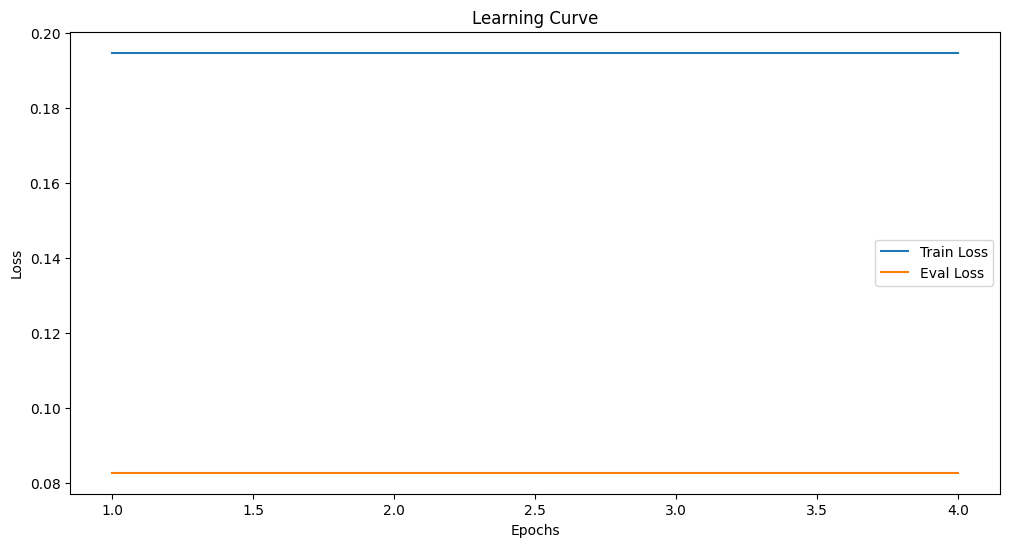

In [53]:
epochs = list(range(1, training_args.num_train_epochs + 1))
train_loss = [train_metrics['train_loss'] for epoch in epochs]
eval_loss = [eval_metrics['eval_loss'] for epoch in epochs]

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, eval_loss, label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

##### Learning curve : tailledu dataset

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments

def learning_curve(model, train_dataset, test_dataset, training_args, sizes, metric='f1'):
    train_sizes = []
    train_scores = []
    test_scores = []

    for size in sizes:
        subset_indices = np.random.choice(len(train_dataset), size, replace=False)
        train_subset = torch.utils.data.Subset(train_dataset, subset_indices)
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_subset,
            eval_dataset=test_dataset,
        )
        
        trainer.train()
        
        train_result = trainer.predict(train_subset)
        test_result = trainer.predict(test_dataset)
        
        train_preds = train_result.predictions.argmax(-1)
        test_preds = test_result.predictions.argmax(-1)
        
        train_score = f1_score(train_result.label_ids, train_preds, average='macro')
        test_score = f1_score(test_result.label_ids, test_preds, average='macro')
        
        train_sizes.append(size)
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    return train_sizes, train_scores, test_scores

sizes = [100, 200, 500, 1000, 2000, len(train_dataset)]

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,              
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,
)

train_sizes, train_scores, test_scores = learning_curve(model, train_dataset, test_dataset, training_args, sizes)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores, label='Train F1 Score')
plt.plot(train_sizes, test_scores, label='Test F1 Score')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

c:\Users\fvenezia\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


















































                                                   

                                         
 92%|█████████▏| 280/304 [1:15:09<01:32,  3.84s/it]



{'eval_loss': 0.08109775185585022, 'eval_runtime': 48.2304, 'eval_samples_per_second': 16.4, 'eval_steps_per_second': 1.037, 'epoch': 1.0}


                                                   
 92%|█████████▏| 280/304 [1:15:22<01:32,  3.84s/it]

{'loss': 0.0874, 'grad_norm': 0.4541052579879761, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}




















































                                                   

                                         
 92%|█████████▏| 280/304 [1:16:22<01:32,  3.84s/it]



{'eval_loss': 0.07936374098062515, 'eval_runtime': 48.2129, 'eval_samples_per_second': 16.406, 'eval_steps_per_second': 1.037, 'epoch': 2.0}


                                                   
 92%|█████████▏| 280/304 [1:16:46<01:32,  3.84s/it]

{'loss': 0.0855, 'grad_norm': 0.447652667760849, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}




















































                                                   

                                         
 92%|█████████▏| 280/304 [1:17:37<01:32,  3.84s/it]



{'eval_loss': 0.07880435138940811, 'eval_runtime': 49.3787, 'eval_samples_per_second': 16.019, 'eval_steps_per_second': 1.013, 'epoch': 3.0}


                                                   
100%|██████████| 21/21 [03:40<00:00, 10.52s/it]/it]


{'train_runtime': 220.84, 'train_samples_per_second': 1.358, 'train_steps_per_second': 0.095, 'train_loss': 0.08602636626788548, 'epoch': 3.0}


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


ValueError: multiclass-multioutput is not supported

##### Évaluation du modèle

In [ ]:
# Récupère le modèle entraîné à partir de l'instance trainer
model = trainer.model
# Met le modèle en mode évaluation (Cela désactive certaines couches comme le dropout et la normalisation par lot, qui sont utilisées uniquement pendant l'entraînement)
model.eval()

CamembertForTokenClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tr

In [ ]:
def calculate_f1_score(model, dataloader):
    all_predictions = []
    all_labels = []
    
    # Itère à travers chaque lot (batch) du DataLoader fourni en paramètre
    for batch in dataloader:
        # Calcul des prédictions
        # torch.no_grad() indique à PyTorch de ne pas effectuer de calculs de gradients pendant cette phase d'inférence
        with torch.no_grad():
            # Prépare les entrées pour le modèle en déplaçant les données du lot vers le même appareil (CPU ou GPU) que le modèle
            inputs = {key: batch[key].to(model.device) for key in batch}
            # Utilise le modèle pour faire des prédictions sur les données d'entrée du batch
            outputs = model(**inputs)
            # Récupère les logits (sorties brutes du modèle)
            logits = outputs.logits
            # Utilise torch.argmax pour obtenir les indices des prédictions les plus probables pour chaque token
            predictions = torch.argmax(logits, dim=2)
            
            # Stockage des prédictions et des étiquette
            # Convertit les prédictions en un tableau NumPy et les aplatit, puis les ajoute à la liste all_predictions
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_labels.extend(inputs["labels"].cpu().numpy().flatten())
    
    f1 = f1_score(all_labels, all_predictions, average='macro') # macro : calcule le F1 score pour chaque classe et en fait la moyenne, en traitant toutes les classes de manière égale
    cm = confusion_matrix(all_labels, all_predictions)

    return f1, cm

C'est quoi un DataLoader ?

Un DataLoader en PyTorch est une structure qui vous permet de charger et d'itérer efficacement sur un ensemble de données pendant l'entraînement ou l'évaluation de votre modèle. Il simplifie la gestion des données en les chargeant par lots (batches) et en les préparant pour être utilisées par votre modèle.

F1 Score: 0.3879557533818573
F1 Score: 38.80%


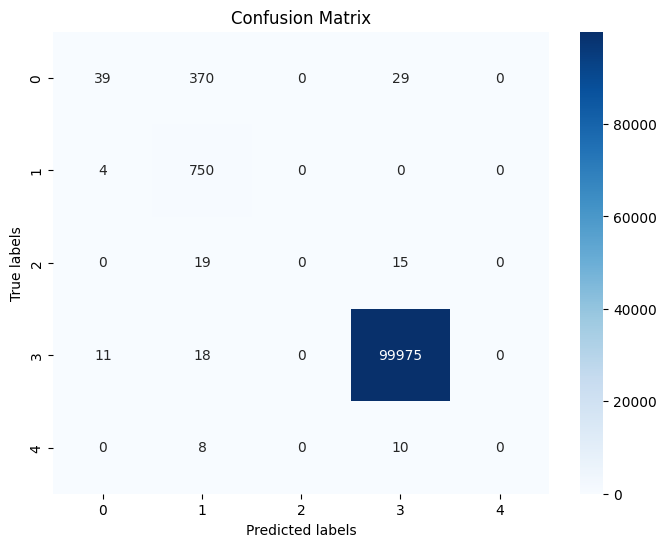

In [ ]:
# création d'un DataLoader pour l'ensemble de données de test avec une taille de lot de 16
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Utilise la fonction calculate_f1_score pour calculer le F1 score et la matrice de confusion en utilisant le modèle et le DataLoader de test
f1_score, confusion_mat = calculate_f1_score(model, test_dataloader)

print("F1 Score:", f1_score)
f1_score_percentage = f1_score * 100
print("F1 Score:", f"{f1_score_percentage:.2f}%")

# Crée une nouvelle figure avec une taille de 8x6 pouces
plt.figure(figsize=(8, 6))
# Utilise seaborn pour afficher la matrice de confusion sous forme de heatmap. Les annotations sont
# ajoutées (annot=True), le format est défini comme des entiers (fmt='d'), et la colormap est définie sur Blues
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
# Ajoute des étiquettes aux axes et un titre à la figure
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
# Affiche la figure
plt.show()

# 'I_ville_arrivée': 0, 'I_ville_départ': 1, 'B_ville_départ': 2, 'O': 3, 'B_ville_arrivée': 4

### Tester le modèle avec 1 phrase

In [75]:
def test_single_sentence(sentence, tokenizer, model, label_map):
    # Tokeniser la phrase sans padding pour obtenir la longueur réelle
    encoding = tokenizer(sentence, truncation=True, padding=False, return_tensors='pt', is_split_into_words=True)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    real_length = input_ids.size(1)

    # Tokeniser la phrase avec padding pour l'entrée du modèle
    encoding = tokenizer(sentence, truncation=True, padding='max_length', max_length=128, return_tensors='pt', is_split_into_words=True)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Afficher les tokens générés par le tokenizer
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    print(f"Tokens: {tokens}")

    # Faire des prédictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2)

    # Afficher les prédictions brutes du modèle
    print(f"Predictions: {predictions[0].cpu().numpy()}")

    # Convertir les prédictions en labels
    predicted_labels = [list(label_map.keys())[list(label_map.values()).index(label_id)] for label_id in predictions[0].cpu().numpy()[:real_length]]
    print(f"Predicted Labels: {predicted_labels}")

    # Identifier les mots correspondant à B_ville_départ et B_ville_arrivée
    tokens = tokens[:real_length]
    departure_city = []
    arrival_city = []
    current_word = []
    current_label = None

    for token, label in zip(tokens, predicted_labels):
        if token.startswith('▁'):
            if current_word:
                word = tokenizer.convert_tokens_to_string(current_word).replace('▁', ' ').strip()
                if current_label == 'B_ville_départ' or current_label == 'I_ville_départ':
                    departure_city.append(word)
                elif current_label == 'B_ville_arrivée' or current_label == 'I_ville_arrivée':
                    arrival_city.append(word)
                current_word = []
            current_label = label
        current_word.append(token)

    # Ajouter le dernier mot
    if current_word:
        word = tokenizer.convert_tokens_to_string(current_word).replace('▁', ' ').strip()
        if current_label == 'B_ville_départ' or current_label == 'I_ville_départ':
            departure_city.append(word)
        elif current_label == 'B_ville_arrivée' or current_label == 'I_ville_arrivée':
            arrival_city.append(word)

    return ' '.join(departure_city), ' '.join(arrival_city)

In [76]:
sentence = "Quel est le prochain train de Dijon à Manosque ?"
departure_city, arrival_city = test_single_sentence(sentence, tokenizer, model, label_map)

print(f"Phrase: {sentence}")
print(f"Ville de départ: {departure_city}")
print(f"Ville d'arrivée: {arrival_city}")

Tokens: ['<s>', '▁Quel', '▁est', '▁le', '▁prochain', '▁train', '▁de', '▁Dijon', '▁à', '▁Man', 'osque', '▁?', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

##### Matrices de confusion

In [ ]:
conf_matrix = confusion_matrix(flat_true_labels, flat_pred_labels, labels=list(label_map.keys()), normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

NameError: name 'flat_pred_labels' is not defined